---

## **Smile Factory Production Data** (Jordan Dacanay)
### **Data Exploration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/APM1215/SA1/TimeSeries_Dataset3.csv")
df

,Month,Production
0,2010-01-31,100.000000
1,2010-02-28,89.969672
2,2010-03-31,78.865312
3,2010-04-30,71.390332
4,2010-05-31,59.468189
...,...,...
75,2016-04-30,-94.037875
76,2016-05-31,-90.927556
77,2016-06-30,-91.449405
78,2016-07-31,-85.065333


### **A. Renaming Months**

In [ ]:
df_copy = df.copy()

dt = pd.to_datetime(df_copy["Month"].str.strip("-"), format="%Y-%m-%d", errors="coerce")
df_copy["Month"] = dt.dt.strftime("%B %Y")
df_copy

,Month,Production
0,January 2010,100.000000
1,February 2010,89.969672
2,March 2010,78.865312
3,April 2010,71.390332
4,May 2010,59.468189
...,...,...
75,April 2016,-94.037875
76,May 2016,-90.927556
77,June 2016,-91.449405
78,July 2016,-85.065333


#### Plot of Smile Factory Monthly Production (2010-2016)

<Axes: xlabel='Month'>

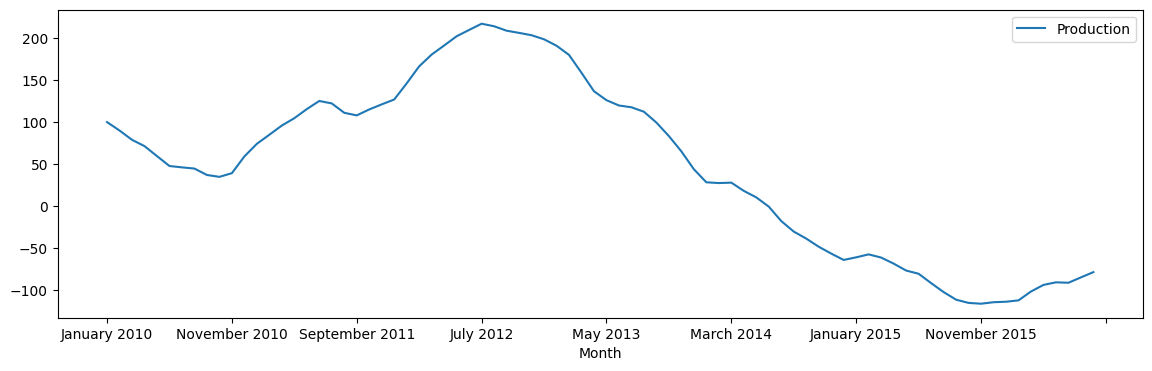

In [ ]:
df_copy.plot(x="Month", y="Production", figsize=(14, 4))


#### Main Features

##### 1. Trend
Based on the plot, the trend appears to be spline where it begins from a downward to an upward trend until a total downward trend in the end.
##### 2. Seasonality
As shown by the plot, the series does not indicate any sign of seasonality.
##### 3. Noise
According to the plot, there is no obvious or isolated outliers and fluctuations look fairly smooth.
##### 4. Autocorrelation
Based on the plot, the series shows strong positive autocorrelation at short lags and a slowly decaying ACF driven by trend.

#### Statistical Summary

In [ ]:
import numpy as np
from scipy import stats

# Time-indexed Series
s = (df.dropna(subset=["Month"])
       .set_index("Month")["Production"]
       .astype(float)
       .sort_index())

desc = s.describe()  # count, mean, std, min, 25%, 50%, 75%, max
extra = pd.Series({
    "cv": (desc["std"] / desc["mean"]) if desc["mean"] != 0 else np.nan,     # coefficient of variation
    "skewness": stats.skew(s, bias=False, nan_policy="omit"),
    "kurtosis": stats.kurtosis(s, fisher=True, bias=False, nan_policy="omit"),
    "autocorr_lag1": s.autocorr(1),
})

summary = pd.concat([desc, extra])
summary

,0
count,80.000000
mean,47.740550
std,104.030098
min,-116.439727
25%,-58.516571
50%,59.278801
75%,121.399932
max,217.236368
cv,2.179072
skewness,-0.100555


The mean, standard deviation, and coefficient of variation of the series indicates very high relative variability, where values swing widely around the average. The meduan being greater than the mean suggests some weight on the negative side pulling the mean down. The skewness indicates a roughly symmetric (slight left tail) dataset. The kurtosis shows lighter tails/flatter peak than normal; fewer extreme values than a normal with same variance. The autocorrelation score suggests that adjacent points in the series are almost the same.

### **Assumption Check**

#### A. Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def prep_series(df, tcol="Month", ycol="Production"):
    out = df.copy()
    out["Month_dt"] = pd.to_datetime(out[tcol], format="%B %Y", errors="coerce")
    s = (out.dropna(subset=["Month_dt", ycol])
            .set_index("Month_dt")[ycol]
            .astype(float)
            .sort_index())
    return s

def adf_kpss_report(s, regression="c", label="series"):
    s = s.dropna()
    adf_stat, adf_p, *_ = adfuller(s, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(s, regression=regression, nlags="auto")
    print(f"[{label}] ADF p (H0: non-stationary) = {adf_p:.4g}")
    print(f"[{label}] KPSS p (H0: stationary)     = {kpss_p:.4g}")
    if adf_p < 0.05 and kpss_p > 0.05:
        print("Stationary (by ADF+KPSS).\n")
        return True
    elif adf_p >= 0.05 and kpss_p <= 0.05:
        print("Clearly non-stationary.\n")
        return False
    else:
        print("Mixed signals.\n")
        return None

def minimal_differencing(s, season=None):
    # Step 1: first difference only
    s_d1 = s.diff().dropna()
    ok = adf_kpss_report(s_d1, regression="c", label="diff(1)")
    if ok is True:
        return s_d1, {"d":1, "D":0, "s":season}
    # Step 2: optionally add seasonal differencing if requested
    if (ok is not True) and season:
        s_both = s.diff(season).diff().dropna()
        ok2 = adf_kpss_report(s_both, regression="c", label=f"diff({season})+diff(1)")
        if ok2 is True:
            return s_both, {"d":1, "D":1, "s":season}

    return s_d1, {"d":1, "D":0, "s":season}


# Apply
s = prep_series(df_copy)

# Original (use 'ct' since trend likely present)
adf_kpss_report(s, regression="ct", label="original")

# NO seasonal differencing first — start with d=1
s_stat, orders = minimal_differencing(s, season=None)
print("Chosen differencing:", orders)


[original] ADF p (H0: non-stationary) = 0.6714
[original] KPSS p (H0: stationary)     = 0.01
Clearly non-stationary.

[diff(1)] ADF p (H0: non-stationary) = 0.1596
[diff(1)] KPSS p (H0: stationary)     = 0.1
Mixed signals.

Chosen differencing: {'d': 1, 'D': 0, 's': None}


/tmp/ipython-input-1510591777.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression=regression, nlags="auto")
/tmp/ipython-input-1510591777.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression=regression, nlags="auto")


The original series is clearly non-stationary, as the ADF test fails to reject a unit root while the KPSS test rejects stationarity. After a first difference (with no seasonal differencing), the evidence becomes mixed but acceptable. ADF does not fully confirm stationarity (p≈0.16), while KPSS does not reject it (p≈0.10). This is a common outcome when most of the trend has been removed. Hence, we can initially model the first-differenced series with d=1 and D=0.

#### B. Autocorrelation

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test: Ljung–Box (H0: no autocorrelation up to lag h)
lb = acorr_ljungbox(s.dropna(), lags=[12, 24], return_df=True)
print("Ljung–Box p-values:")
print(lb)

Ljung–Box p-values:
       lb_stat      lb_pvalue
12  665.792166  9.204129e-135
24  740.943873  5.946872e-141


The p-values are nearly zero ($≈ 9.2×10^{-135}$ and $5.9×10^{-141}$). Hence, the Ljung–Box test strongly rejects “no autocorrelation” up to lags 12 and 24.

#### C. Residual Behavior

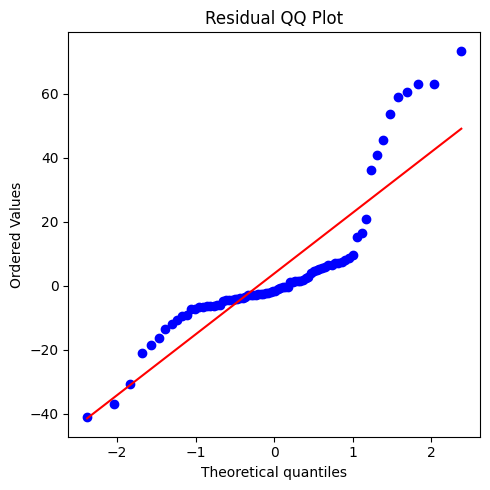

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as st

y = (df_copy.assign(Month_dt=pd.to_datetime(df_copy["Month"], format="%B %Y", errors="coerce"))
       .dropna(subset=["Month_dt","Production"])
       .set_index("Month_dt")["Production"]
       .astype(float).sort_index())

res = STL(y, period=12, robust=True).fit()
r = res.resid.dropna()

# Residual behavior check
plt.figure(figsize=(5,5)); st.probplot(r, dist="norm", plot=plt); plt.title("Residual QQ Plot"); plt.tight_layout(); plt.show()


### **Model Building**

#### A. ARIMA

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

y = y.asfreq("MS")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    m = ARIMA(
        y, order=(1,1,1),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(
        method="statespace",
        method_kwargs={"maxiter": 200, "disp": 0}
    )

print(m.summary())
print(acorr_ljungbox(m.resid.dropna(), lags=[12,24], return_df=True))

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -236.456
Date:                Fri, 10 Oct 2025   AIC                            478.912
Time:                        21:52:46   BIC                            485.944
Sample:                    01-01-2010   HQIC                           481.725
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6912      0.106      6.517      0.000       0.483       0.899
ma.L1          0.4886      0.137      3.555      0.000       0.219       0.758
sigma2        27.1961      4.134      6.578      0.0

#### B. Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def fit_ets(y, damped=True):
    m = ExponentialSmoothing(y, trend="add", seasonal=None, damped_trend=damped).fit(optimized=True)
    # Fake an AIC-like score for rough comparison (ETS doesn’t expose AIC reliably in statsmodels)
    aic_like = np.log(m.sse/len(y)) + 2*len(m.params)/len(y)
    return {"model": m, "name": f"ETS(AdditiveTrend, damped={damped})", "AIC": aic_like}

ets_add  = fit_ets(y, damped=False)
ets_damp = fit_ets(y, damped=True)

#### C. Regression + AR(1) errors (Cochrane–Orcutt / GLSAR)

In [ ]:
import statsmodels.api as sm

def fit_reg_glsar(y):
    t = np.arange(len(y), dtype=float)
    X = sm.add_constant(pd.DataFrame({"t": t}, index=y.index))
    glsar = sm.GLSAR(y, X, rho=1)
    res = glsar.iterative_fit(maxiter=10)  # Cochrane–Orcutt-like
    # Ljung–Box on residuals
    r = pd.Series(res.resid, index=y.index)
    lb = acorr_ljungbox(r.dropna(), lags=[12,24], return_df=True)
    # AIC proxy: –2*loglik not available; use log SSE per obs + penalty
    aic_like = np.log((r**2).mean()) + 2*len(res.params)/len(y)
    return {"model": res, "name": "Reg(t)+AR(1) (GLSAR)", "AIC": aic_like,
            "LB_p12": float(lb['lb_pvalue'].iloc[0]), "LB_p24": float(lb['lb_pvalue'].iloc[1])}

reg_glsar = fit_reg_glsar(y)

### **Model Evaluation**

#### A. Helpers (metrics, walk-forward)

In [ ]:
import warnings, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(a, f):
    return float(np.sqrt(mean_squared_error(a, f)))

def mape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    mask = np.isfinite(a) & (a != 0)
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((a[mask]-f[mask]) / a[mask]))*100)

def walk_forward(series, model_maker, initial_frac=0.7, horizon=1):
    """One-step (or h-step) rolling-origin evaluation.
       model_maker(history) must return a fitted model with .forecast(steps)."""
    series = series.dropna()
    split = int(len(series)*initial_frac)
    hist = series.iloc[:split].copy()
    test = series.iloc[split:].copy()
    preds = []

    for i in range(len(test)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = model_maker(hist)
        fc = model.forecast(horizon)
        preds.append(fc.iloc[-1] if hasattr(fc, "iloc") else fc[-1])
        # reveal next actual point and continue
        hist = pd.concat([hist, test.iloc[[i]]])

    preds = pd.Series(preds, index=test.index)
    return preds, test

#### B. Models

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def mk_arima(order=(1,1,1)):
    def _maker(history):
        return ARIMA(history.asfreq('MS'), order=order,
                     enforce_stationarity=False, enforce_invertibility=False
                    ).fit(method="statespace", method_kwargs={"disp":0})
    return _maker

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def mk_ets(damped=True):
    def _maker(history):
        return ExponentialSmoothing(history.asfreq('MS'), trend="add",
                                    seasonal=None, damped_trend=damped
                                   ).fit(optimized=True)
    return _maker

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

def mk_glsar_ar1():
    def _maker(history):
        h = history.asfreq('MS')
        t = np.arange(len(h), dtype=float)
        X = pd.DataFrame({"const": 1.0, "t": t}, index=h.index)
        glsar = sm.GLSAR(h, X, rho=1)
        res = glsar.iterative_fit(maxiter=10)

        # keep the exact exog column names / order used in training
        exog_names = res.model.exog_names  # e.g., ['const','t']

        class _F:
            def __init__(self, res, last_index, exog_names):
                self.res = res
                self.last_index = last_index
                self.exog_names = exog_names

            def forecast(self, steps=1):
                # one-step-ahead only (called by walk_forward with horizon=1)
                n = len(self.res.model.endog)
                X_next = pd.DataFrame({
                    "const": [1.0],
                    "t":     [float(n)]
                })
                # ensure column order matches training
                X_next = X_next[self.exog_names]
                yhat = float(self.res.predict(X_next)[0])
                next_index = self.last_index + pd.offsets.MonthBegin(1)
                return pd.Series([yhat], index=[next_index])

        return _F(res, h.index[-1], exog_names)
    return _maker

#### Rolling-origin evaluation

In [ ]:
y = y.asfreq('MS')
pred_arima, test = walk_forward(y, mk_arima((1,1,1)))
pred_ets,   _    = walk_forward(y, mk_ets(damped=True))
pred_glsar, _    = walk_forward(y, mk_glsar_ar1())

eval_table = pd.DataFrame({
    "MAE":  [mean_absolute_error(test, pred_arima),
             mean_absolute_error(test, pred_ets),
             mean_absolute_error(test, pred_glsar)],
    "RMSE": [rmse(test, pred_arima),
             rmse(test, pred_ets),
             rmse(test, pred_glsar)],
    "MAPE%":[mape(test, pred_arima),
             mape(test, pred_ets),
             mape(test, pred_glsar)]
}, index=["ARIMA", "ETS", "Reg+AR(1)"])
print(eval_table.sort_values("RMSE"))

                  MAE        RMSE       MAPE%
ETS          3.200187    4.226552    4.127766
ARIMA        3.527727    4.448309    4.457467
Reg+AR(1)  167.086404  183.818251  238.442516


## **V. Recommendation**

Based on the evaluation results, the recommended forecasting method is ETS (additive trend, damped), which achieved the best accuracy with the lowest MAE (3.20), RMSE (4.23), and MAPE (4.13%). It performed better than ARIMA (MAE 3.53, RMSE 4.45, MAPE 4.46%) and  Regression + AR(1) (RMSE ≈ 183.82). This choice aligns with the data’s non-seasonal structure, and offers a  arsimonious and stable model that is easy to update and interpret (it captures a damped trend consistent with the observed rise-then-decline).